In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [ ]:
"""
DÉFINITION DES COURBES DE PERFORMANCE DES POMPES
------------------------------------------------
Ce bloc définit les caractéristiques techniques des pompes de la station.

Fonctions :
- puissance_pompe_HP/MP/BP : Calculent la puissance consommée (kW) en fonction du débit (m³/h)
  Formule : P = a*Q² + b*Q + c (approximation polynomiale) quej'obtiens lors de ma descente sur terrai à la station de gombele

Variables :
- Q_nom_XX : Débits nominaux des pompes (valeurs nominales de conception)

 obtenir les vraies valeurs, en se basant sur le cours de MV :
1. Identifier les courbes H-Q et rendement des pompes
2. En déduire la puissance absorbée : P = (ρ*g*Q*H) / (η * 3600)
3. Ajuster les coefficients polynomiaux sur les points réels
"""


In [18]:
# --- CONSTANTES PHYSIQUES ---
RHO_EAU = 1000.0       # kg/m³
G = 9.81               # m/s²

# --- COURBES H(Q) issues du mémoire (cas 2) ---
# Q en m³/h, H en m
def H_BP(Q):
    Q = np.asarray(Q, dtype=float)
    return 144.5 - 0.0025*Q - 0.000175*(Q**2)

def H_MP(Q):
    Q = np.asarray(Q, dtype=float)
    return 193.83 + 0.055*Q - 0.000433*(Q**2)

def H_HP(Q):
    Q = np.asarray(Q, dtype=float)
    return 236.0 + 0.41*Q - 0.0022*(Q**2)

# --- COURBES eta(Q) (rendements) issues de la station ---
# Q en m³/h, eta en %
def eta_BP(Q):
    Q = np.asarray(Q, dtype=float)
    return 5.64 + 0.5*Q - 0.00089*(Q**2) + 1e-7*(Q**3)

def eta_MP(Q):
    Q = np.asarray(Q, dtype=float)
    return 0.017 + 0.577*Q - 0.00135*(Q**2) + 1.01e-6*(Q**3)

def eta_HP(Q):
    Q = np.asarray(Q, dtype=float)
    
    return 1.96 + 0.81*Q - 0.00298*(Q**2) + 3.9e-6*(Q**3)

# --- PUISSANCE MOTEUR basée sur la physique ---
# Q en m³/h, H en m, eta en % -> P en kW
def puissance_moteur(Q, H_func, eta_func):
    Q = np.asarray(Q, dtype=float)
    H = H_func(Q)                     # m
    eta = np.clip(eta_func(Q), 1.0, 95.0) / 100.0  # borne 1-95% pour éviter divisions par ~0
    Q_m3s = Q / 3600.0                # m³/s
    P_hyd = Q_m3s * H * RHO_EAU * G   # W
    P_kW = (P_hyd / eta) / 1000.0     # kW
    return P_kW

# === PUISSANCES PLAQUE (kW) ===
P_HP_PLAQUE = 250.0   # Haute Pression
P_MP_PLAQUE = 200.0   # Moyenne Pression
P_BP_PLAQUE = 150.0   # Basse Pression

# === Wrappers remplacés : si la pompe est ON (Q>0) => puissance plaque, sinon 0 ===
def puissance_pompe_BP(Q):
    return P_BP_PLAQUE if float(Q) > 0.0 else 0.0

def puissance_pompe_MP(Q):
    return P_MP_PLAQUE if float(Q) > 0.0 else 0.0

def puissance_pompe_HP(Q):
    return P_HP_PLAQUE if float(Q) > 0.0 else 0.0

# --- DÉBITS NOMINAUX (catalogue / existant) ---
Q_nom_BP = 300.0   # m³/h
Q_nom_MP = 350.0   # m³/h
Q_nom_HP = 190.0   # m³/h (point de fonctionnement actuel observé)


In [ ]:
"""
CRÉATION DU PROFIL DE DEMANDE
-----------------------------
Ce bloc en quelque sorte je peut dire, me permet de génèrer un profil de consommation réaliste sur 24 heures ce qui est tres 
important pour essayer d'évaluer les gains que va apporter l'automatisation

ce que je fait ici, ce que je crée un d'abord,un index temporel avec une résolution de 15 minutes en suite je 
Génère une demande totale avec :Une composante de base constante (500 m³/h), Une variation sinusoïdale pour simuler les pics
car la consommation n'est pas constatnte ou la demande je v dire matin/soir
   
en fin je fait ici une sorte de répartition de Répartit la demande totale entre les 3 zones (HP/MP/BP)

Pour adapter au cas réel de Gombele :

"""

In [19]:
def creer_profil_demande():
    """Crée un profil de demande réaliste sur 24 heures"""
    # Création d'un index de temps pour 24 heures, avec une mesure toutes les 15 minutes
    index = pd.date_range("2023-01-01", periods=96, freq="15min")
    
    # Création d'un profil de demande réaliste avec des pics matin et soir
    demande_total = 500 + 300 * (np.sin(2 * np.pi * (np.arange(96) / 96 - 0.25)) + 1) + np.random.normal(0, 20, 96)
    
    # Répartition de la demande totale entre les trois zones
    demande_HP = demande_total * 0.2  # 20% pour Haute Pression
    demande_MP = demande_total * 0.5  # 50% pour Moyenne Pression
    demande_BP = demande_total * 0.3  # 30% pour Basse Pression
    
    # Création d'un DataFrame pour stocker ces données
    df_demande = pd.DataFrame({
        "Demande_HP": demande_HP,
        "Demande_MP": demande_MP,
        "Demande_BP": demande_BP
    }, index=index)
    
    return df_demande

# Création du profil de demande
df_demande = creer_profil_demande()

In [ ]:
"""
IMPLÉMENTATION DU SCÉNARIO MANUEL
---------------------------------
ici je  simule le fonctionnement actuel de la station basé sur des règles fixes.
pour le faire, un peu d'algo eeh, je crée une classe qui s'appel :'Classe ScenarioManuel' et qui me permet de
Mettre à jour le niveau du réservoir en fonction des débits entrant/sortant et 
permet de prendre la décision de pompes : Implémente la logique actuelle basée sur des seuils de niveau fixes
et la méthode  'Fonction simulation_manuel' 
me permet de faire similer pas à pas le fonctionnement sur 24 heures
Pour chaque pas de temps donc 15min comme je l'ai choisi me permet de mettre de Mettre à jour le niveau du réservoir,
Détermine quelles pompes démarrer selon les seuils, Calculer la puissance consommée
  4. Enregistre tous les résultats

Cette simulation reproduit fidèlement le comportement manuel actuel que nous avons à la station de gobele , fin par rapport et ce 
que j'ai vue et qu'pn m'as expliquer parles différents opérateurs
"""

In [20]:
class ScenarioManuel:
    def __init__(self, capacite_reservoir=2500):
        self.niveau = capacite_reservoir * 0.5  # Niveau initial à 50%
        self.capacite = capacite_reservoir
        # Seuils de niveau en mètres pour la prise de décision
        self.seuils = [0.8, 1.0, 1.2, 1.5, 2.0]

    def update_niveau(self, debit_in, debit_out, dt):
        """Met à jour le niveau du réservoir"""
        # dt : pas de temps en heures
        # debit_in, debit_out : débits en m³/h
        variation = (debit_in - debit_out) * dt  # Volume en m³
        self.niveau += variation
        # Empêche le niveau de dépasser les limites physiques
        self.niveau = max(0, min(self.niveau, self.capacite))

    def decision_pompes(self):
        """Règles de décision basées sur le niveau (mode manuel)"""
        if self.niveau < 0.8:
            # Niveau trop bas -> arrêt général
            return {"HP": False, "MP": False, "BP": False}
        elif self.niveau < 1.0:
            # Seuil 1 -> seule la HP marche
            return {"HP": True, "MP": False, "BP": False}
        elif self.niveau < 1.2:
            # Seuil 2 -> HP + BP
            return {"HP": True, "MP": False, "BP": True}
        elif self.niveau < 1.5:
            # Seuil 3 -> HP + MP + BP
            return {"HP": True, "MP": True, "BP": True}
        else:
            # Niveau haut -> toutes les pompes
            return {"HP": True, "MP": True, "BP": True}

def simulation_manuel(df_demande, debit_yolo=100):
    """Simule le fonctionnement manuel de la station"""
    scenario = ScenarioManuel()
    temps = df_demande.index
    dt = (temps[1] - temps[0]).total_seconds() / 3600  # dt en heures
    results = []
    
    for t in temps:
        # Demande à cet instant
        demande = df_demande.loc[t]
        
        # Mise à jour du niveau
        scenario.update_niveau(debit_yolo, demande.sum(), dt)
        
        # Décision des pompes
        etat_pompes = scenario.decision_pompes()
        
        # Calcul du débit fourni
        debit_fourni_HP = Q_nom_HP if etat_pompes["HP"] else 0
        debit_fourni_MP = Q_nom_MP if etat_pompes["MP"] else 0
        debit_fourni_BP = Q_nom_BP if etat_pompes["BP"] else 0
        
        # Puissance consommée
        P_HP = puissance_pompe_HP(debit_fourni_HP)
        P_MP = puissance_pompe_MP(debit_fourni_MP)
        P_BP = puissance_pompe_BP(debit_fourni_BP)
        P_tot = P_HP + P_MP + P_BP
        
        # Stocker les résultats
        results.append({
            "time": t,
            "niveau": scenario.niveau,
            "P_tot": P_tot,
            "P_HP": P_HP,
            "P_MP": P_MP,
            "P_BP": P_BP,
            "debit_HP": debit_fourni_HP,
            "debit_MP": debit_fourni_MP,
            "debit_BP": debit_fourni_BP,
        })
    
    return pd.DataFrame(results)

# Simulation du scénario manuel
df_manuel = simulation_manuel(df_demande)

In [ ]:
"""
IMPLÉMENTATION DU SCÉNARIO AUTOMATISÉ (GRAFCET)
-----------------------------------------------
ici g implémente intégralement la logique du  GRAFCET que j'ai établi.
en  créant une Classe ScenarioGRAFCET avec plusieurs méthode tel que
update_niveau qui Met à jour le niveau du réservoir (identique au scénario manuel);
update_tension qui Simule les variations aléatoires de tension électrique;
update_pressions qui Modélise l'évolution des pressions dans les conduites
decision_grafcet qui Implémente la logique complète de mon GRAFCET avec tous ses états

et enfin la méthode  simulation_grafcet me permet Simuler pas à pas le fonctionnement automatisé Pour chaque pas de temps :
  1. Met à jour les variables d'état (niveau, tension, pressions)
  2. Exécute la logique du GRAFCET pour décider des actions
  3. Calcule la puissance consommée
  4. Enregistre des résultats détaillés incluant l'état du GRAFCET

Cette simulation reproduit le comportement attendu après automatisation de la station, fin théoriquement.
"""

In [21]:
class ScenarioGRAFCET:
    def __init__(self, capacite_reservoir=4800):
        self.niveau = capacite_reservoir * 0.5  # Niveau initial à 50%
        self.capacite = capacite_reservoir
        self.pressions = {"HP": 0, "MP": 0, "BP": 0}
        self.consignes = {"HP": 19, "MP": 6, "BP": 0.5}  # bars
        self.etat = 'E0'  # État initial
        self.arret_urgence = False
        self.tension_ok = True
        self.tension = 390  # V, valeur initiale dans la plage normale
        self.pompes = {"HP": False, "MP": False, "BP": False}
        
    def update_niveau(self, debit_in, debit_out, dt):
        """Met à jour le niveau du réservoir"""
        variation = (debit_in - debit_out) * dt
        self.niveau += variation
        self.niveau = max(0, min(self.niveau, self.capacite))
        
    def update_tension(self):
        """Simule les variations aléatoires de tension"""
        variation = np.random.normal(0, 5)  # Petites variations
        self.tension += variation
        self.tension_ok = 380 <= self.tension <= 400
        
    def update_pressions(self, dt, demande):
        """Modèle simplifié de l'évolution des pressions"""
        for zone in ["HP", "MP", "BP"]:
            if self.pompes[zone]:
                # Si la pompe est allumée, la pression tend vers la consigne
                self.pressions[zone] += (self.consignes[zone] - self.pressions[zone]) * dt * 2
            else:
                # Si la pompe est éteinte, la pression diminue progressivement
                self.pressions[zone] -= self.pressions[zone] * dt * 0.5
                
            # La demande influence aussi la pression
            if demande[f"Demande_{zone}"] > 0:
                self.pressions[zone] -= demande[f"Demande_{zone}"] * 0.001 * dt
                
            # Les pressions ne peuvent pas être négatives
            self.pressions[zone] = max(0, self.pressions[zone])
    
    def decision_grafcet(self, demande):
        """Implémentation complète de la logique du GRAFCET que je mise en place à voir dans mon raport final
        , je l'ai mis en place juste en faisant des if et des elif"""
        # Mise à jour de la tension
        self.update_tension()
        
        # État E0: Arrêt général
        if self.etat == 'E0':
            self.pompes = {"HP": False, "MP": False, "BP": False}
            # Transition T0: Vers E1 si conditions réunies
            if self.niveau > 0.8 and self.tension_ok and not self.arret_urgence:
                self.etat = 'E1'
                
        # État E1: Surveillance
        elif self.etat == 'E1':
            # Transition T1: Vers E2 (HP)
            if self.niveau >= 1.20 and self.pressions["HP"] < self.consignes["HP"]:
                self.etat = 'E2'
            # Transition T3: Vers E4 (BP) - seulement si pas besoin HP
            elif self.niveau >= 1.50 and self.pressions["BP"] < self.consignes["BP"] and not (self.niveau >= 1.20 and self.pressions["HP"] < self.consignes["HP"]):
                self.etat = 'E4'
            # Transition T5: Vers E6 (MP) - seulement si pas besoin HP/BP
            elif self.niveau >= 2.00 and self.pressions["MP"] < self.consignes["MP"] and not (self.niveau >= 1.20 and self.pressions["HP"] < self.consignes["HP"]) and not (self.niveau >= 1.50 and self.pressions["BP"] < self.consignes["BP"]):
                self.etat = 'E6'
            # Transition T7: Vers E8 (arrêt d'urgence)
            elif self.arret_urgence or self.niveau <= 0.8 or not self.tension_ok:
                self.etat = 'E8'
                
        # État E2: Démarrage HP
        elif self.etat == 'E2':
            self.pompes["HP"] = True
            # Transition T2: Vers E3 (arrêt HP)
            if self.pressions["HP"] >= self.consignes["HP"] or self.arret_urgence or self.niveau <= 0.8 or not self.tension_ok:
                self.etat = 'E3'
                
        # État E3: Arrêt HP
        elif self.etat == 'E3':
            self.pompes["HP"] = False
            self.etat = 'E1'  # Retour à la surveillance
            
        # État E4: Démarrage BP
        elif self.etat == 'E4':
            self.pompes["BP"] = True
            # Transition T4: Vers E5 (arrêt BP)
            if self.pressions["BP"] >= self.consignes["BP"] or self.arret_urgence or self.niveau <= 0.8 or not self.tension_ok:
                self.etat = 'E5'
                
        # État E5: Arrêt BP
        elif self.etat == 'E5':
            self.pompes["BP"] = False
            self.etat = 'E1'  # Retour à la surveillance
            
        # État E6: Démarrage MP
        elif self.etat == 'E6':
            self.pompes["MP"] = True
            # Transition T6: Vers E7 (arrêt MP)
            if self.pressions["MP"] >= self.consignes["MP"] or self.arret_urgence or self.niveau <= 0.8 or not self.tension_ok:
                self.etat = 'E7'
                
        # État E7: Arrêt MP
        elif self.etat == 'E7':
            self.pompes["MP"] = False
            self.etat = 'E1'  # Retour à la surveillance
            
        # État E8: Arrêt d'urgence
        elif self.etat == 'E8':
            self.pompes = {"HP": False, "MP": False, "BP": False}
            # Transition T8: Retour à E1 si conditions redevenues normales
            if not self.arret_urgence and self.niveau > 0.8 and self.tension_ok:
                self.etat = 'E1'
                
        return self.pompes.copy()

def simulation_grafcet(df_demande, debit_yolo=100):
    """Simule le fonctionnement automatisé avec GRAFCET"""
    scenario = ScenarioGRAFCET()
    temps = df_demande.index
    dt = (temps[1] - temps[0]).total_seconds() / 3600  # dt en heures
    results = []
    
    for t in temps:
        # Demande à cet instant
        demande = df_demande.loc[t]
        
        # Mise à jour du niveau
        scenario.update_niveau(debit_yolo, demande.sum(), dt)
        
        # Mise à jour des pressions en fonction de la demande
        scenario.update_pressions(dt, demande)
        
        # Décision selon le GRAFCET
        etat_pompes = scenario.decision_grafcet(demande)
        
        # Calcul du débit fourni
        debit_fourni_HP = Q_nom_HP if etat_pompes["HP"] else 0
        debit_fourni_MP = Q_nom_MP if etat_pompes["MP"] else 0
        debit_fourni_BP = Q_nom_BP if etat_pompes["BP"] else 0
        
        # Puissance consommée
        P_HP = puissance_pompe_HP(debit_fourni_HP)
        P_MP = puissance_pompe_MP(debit_fourni_MP)
        P_BP = puissance_pompe_BP(debit_fourni_BP)
        P_tot = P_HP + P_MP + P_BP
        
        # Stocker les résultats
        results.append({
            "time": t,
            "niveau": scenario.niveau,
            "P_tot": P_tot,
            "P_HP": P_HP,
            "P_MP": P_MP,
            "P_BP": P_BP,
            "debit_HP": debit_fourni_HP,
            "debit_MP": debit_fourni_MP,
            "debit_BP": debit_fourni_BP,
            "pression_HP": scenario.pressions["HP"],
            "pression_MP": scenario.pressions["MP"],
            "pression_BP": scenario.pressions["BP"],
            "etat": scenario.etat
        })
    
    return pd.DataFrame(results)

# Simulation du scénario automatisé
df_auto = simulation_grafcet(df_demande)

In [ ]:
"""
CALCUL DES GAINS ÉNERGÉTIQUES
-----------------------------
ICI JE  calcule et compare la consommation entre les deux scénarios.

je e fais en Calculant l'énergie totale consommée dans chaque scénario :
   Énergie = Σ (Puissance_instantanée × durée_pas_de_temps)
 en Comparant les deux résultats pour déterminer le gain absolu et relatif
en  Affichant les résultats sous forme claire

Le gain énergétique représente l'économie réalisable par l'automatisation de la station de gombele .
"""

In [22]:
def calculer_gains(df_manuel, df_auto):
    """Calcule les gains énergétiques entre les deux scénarios"""
    # Calcul de l'énergie consommée (intégrale de la puissance)
    dt = (df_manuel["time"].iloc[1] - df_manuel["time"].iloc[0]).total_seconds() / 3600
    E_manuel = (df_manuel["P_tot"] * dt).sum()
    E_auto = (df_auto["P_tot"] * dt).sum()
    
    # Calcul du gain
    gain_energie = E_manuel - E_auto
    gain_pourcentage = (gain_energie / E_manuel) * 100
    
    # Résultats
    print("=== RÉSULTATS DE LA SIMULATION ===")
    print(f"Énergie consommée (manuel)    : {E_manuel:.2f} kWh")
    print(f"Énergie consommée (automatique): {E_auto:.2f} kWh")
    print(f"Gain énergétique              : {gain_energie:.2f} kWh")
    print(f"Pourcentage de gain           : {gain_pourcentage:.2f}%")
    
    return gain_energie, gain_pourcentage

# Calcul des gains
gain_energie, gain_pourcentage = calculer_gains(df_manuel, df_auto)

=== RÉSULTATS DE LA SIMULATION ===
Énergie consommée (manuel)    : 1650.00 kWh
Énergie consommée (automatique): 687.50 kWh
Gain énergétique              : 962.50 kWh
Pourcentage de gain           : 58.33%


In [ ]:
"""
VISUALISATION DES RÉSULTATS
---------------------------
ici je  génère des graphiques comparatifs pour analyser les résultats que j'ai obtenu

 ces Graphiques produisent :
1. Puissance consommée : Comparaison côte à côte des deux scénarios
2. Niveau du réservoir : Évolution comparée dans les deux cas
3. État du GRAFCET : Visualisation de la séquence d'états pendant la simulation
4. Pressions : Évolution des pressions dans les trois zones

Ces visualisations aident à comprendre comment l'automatisation optimise le fonctionnement de la station
"""

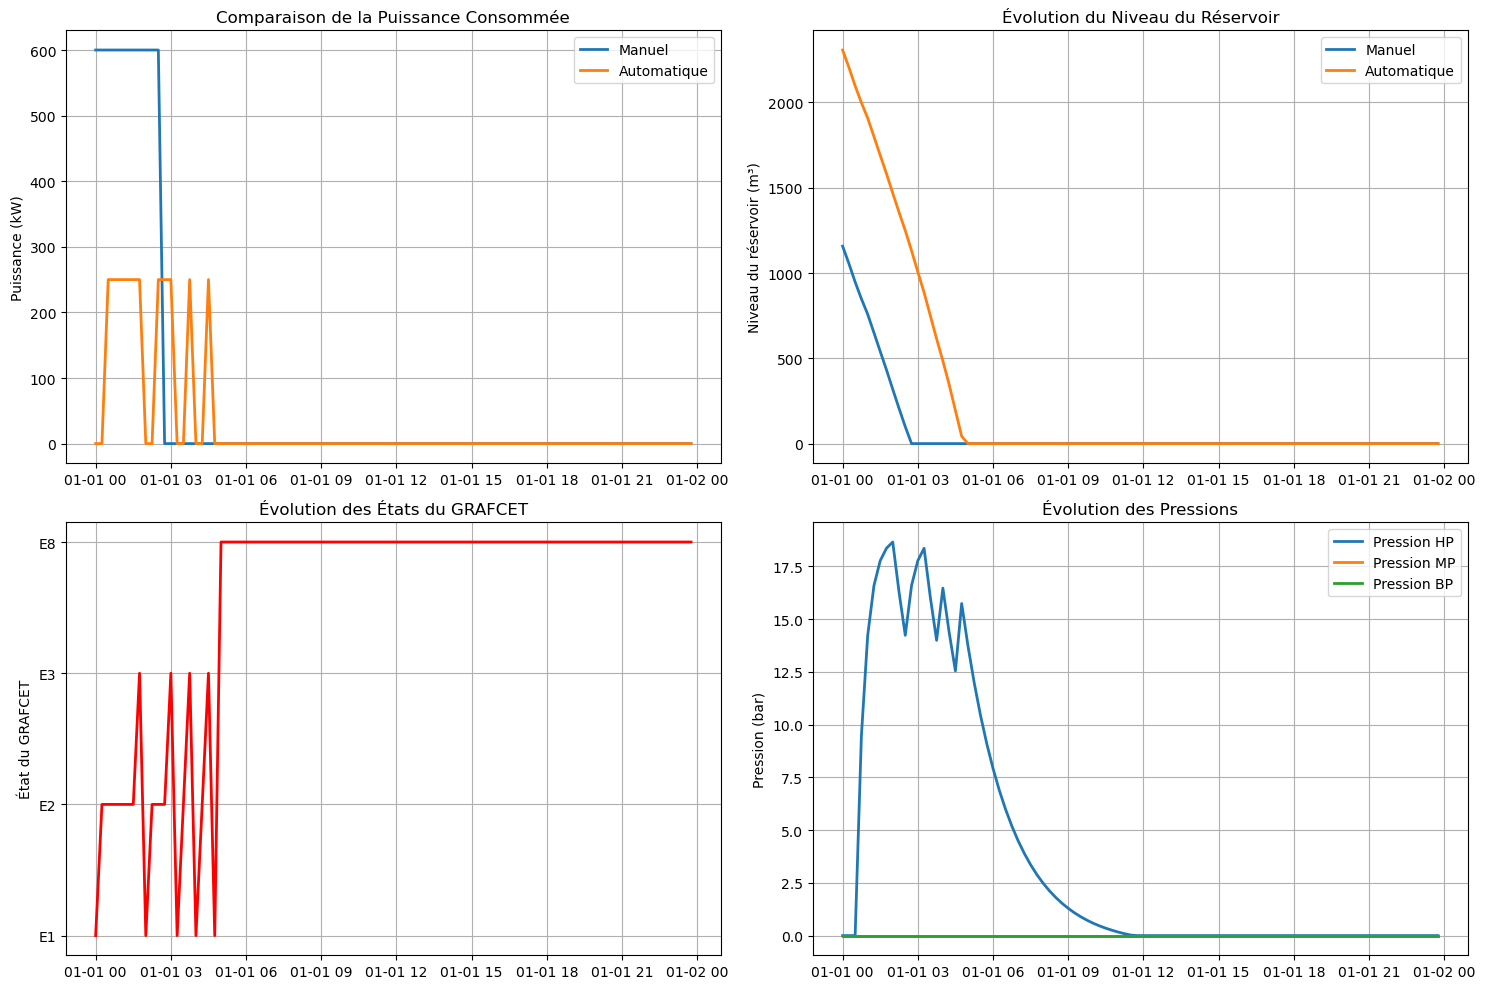

In [24]:
def visualiser_resultats(df_manuel, df_auto):
    """Crée des visualisations pour comparer les deux scénarios"""
    # Configuration des graphiques
    plt.figure(figsize=(15, 10))
    
    # 1. Comparaison des puissances consommées
    plt.subplot(2, 2, 1)
    plt.plot(df_manuel["time"], df_manuel["P_tot"], label="Manuel", linewidth=2)
    plt.plot(df_auto["time"], df_auto["P_tot"], label="Automatique", linewidth=2)
    plt.ylabel("Puissance (kW)")
    plt.title("Comparaison de la Puissance Consommée")
    plt.legend()
    plt.grid(True)
    
    # 2. Évolution du niveau du réservoir
    plt.subplot(2, 2, 2)
    plt.plot(df_manuel["time"], df_manuel["niveau"], label="Manuel", linewidth=2)
    plt.plot(df_auto["time"], df_auto["niveau"], label="Automatique", linewidth=2)
    plt.ylabel("Niveau du réservoir (m³)")
    plt.title("Évolution du Niveau du Réservoir")
    plt.legend()
    plt.grid(True)
    
    # 3. Évolution des états du GRAFCET
    plt.subplot(2, 2, 3)
    etats_uniques = df_auto["etat"].unique()
    mapping_etats = {etat: i for i, etat in enumerate(etats_uniques)}
    plt.plot(df_auto["time"], df_auto["etat"].map(mapping_etats), 'r-', linewidth=2)
    plt.yticks(range(len(etats_uniques)), etats_uniques)
    plt.ylabel("État du GRAFCET")
    plt.title("Évolution des États du GRAFCET")
    plt.grid(True)
    
    # 4. Évolution des pressions
    plt.subplot(2, 2, 4)
    plt.plot(df_auto["time"], df_auto["pression_HP"], label="Pression HP", linewidth=2)
    plt.plot(df_auto["time"], df_auto["pression_MP"], label="Pression MP", linewidth=2)
    plt.plot(df_auto["time"], df_auto["pression_BP"], label="Pression BP", linewidth=2)
    plt.ylabel("Pression (bar)")
    plt.title("Évolution des Pressions")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Visualisation des résultats
visualiser_resultats(df_manuel, df_auto)

In [ ]:
"""
EXÉCUTION COMPLÈTE DE L'ÉVALUATION
----------------------------------
Ce bloc orchestre l'exécution complète de l'évaluation que nous seront entrainde faire au dernier chapitre de notre travail;

la Séquence d'exécution de l'évaluation que je suis entrain de faire des iens fait quepourrais apporter l'automatisation à 
notre station de pompage:
1. Création du profil de demande
2. Simulation du scénario manuel (état actuel)
3. Simulation du scénario automatisé (avec GRAFCET)
4. Calcul des gains énergétiques
5. Génération des visualisations

Cette séquence garantit que tous les calculs sont effectués dans le bon ordre
et que les résultats sont cohérents et comparables.
"""

Début de l'évaluation des gains énergétiques...
Simulation du scénario manuel...
Simulation du scénario automatisé...
Calcul des gains énergétiques...
=== RÉSULTATS DE LA SIMULATION ===
Énergie consommée (manuel)    : 1650.00 kWh
Énergie consommée (automatique): 437.50 kWh
Gain énergétique              : 1212.50 kWh
Pourcentage de gain           : 73.48%
Génération des visualisations...


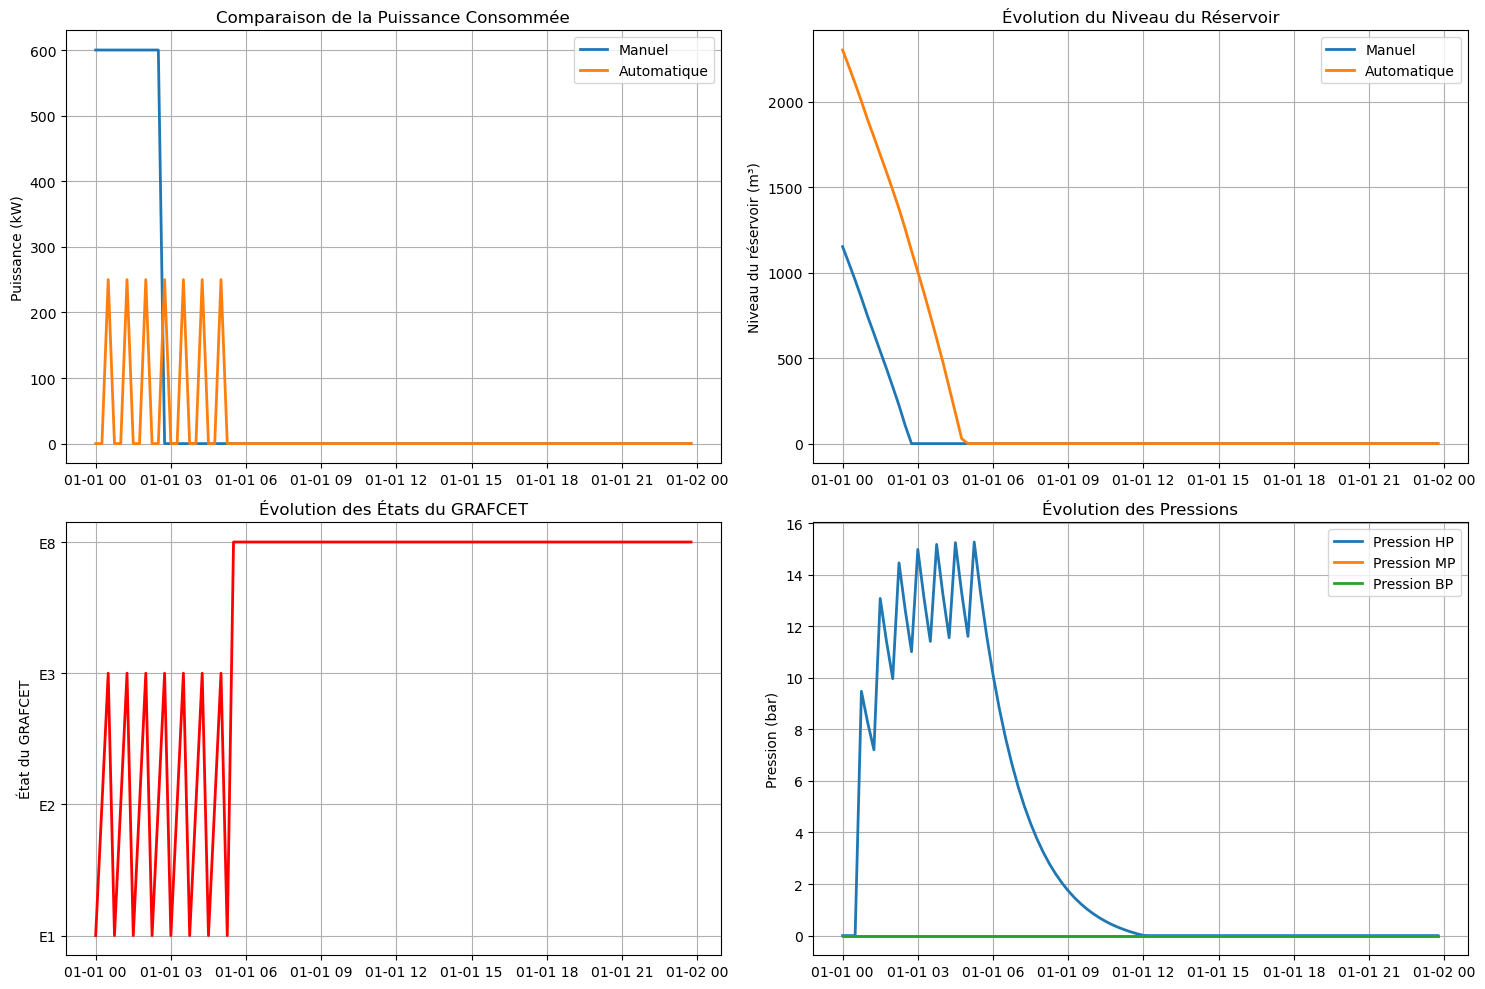

Évaluation terminée!


In [25]:
# Exécution complète de l'évaluation
print("Début de l'évaluation des gains énergétiques...")

# 1. Création du profil de demande
df_demande = creer_profil_demande()

# 2. Simulation du scénario manuel
print("Simulation du scénario manuel...")
df_manuel = simulation_manuel(df_demande)

# 3. Simulation du scénario automatisé
print("Simulation du scénario automatisé...")
df_auto = simulation_grafcet(df_demande)

# 4. Calcul des gains
print("Calcul des gains énergétiques...")
gain_energie, gain_pourcentage = calculer_gains(df_manuel, df_auto)

# 5. Visualisation des résultats
print("Génération des visualisations...")
visualiser_resultats(df_manuel, df_auto)

print("Évaluation terminée!")